# Unbalanced Decision tree - dataset: echo_popul.csv
## Task: Song popularity prediction

In [81]:
%matplotlib inline
 
import pandas as pd
import numpy as np
from utility_functions import report

# sklearn modules 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import plotly.express as px
from statistics import mean
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


In [82]:
echo_popul = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/clean_datasets/echo_popul.csv')
echo_popul.set_index('track_id', inplace=True)
echo_popul.head()

,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,listens,duration,bit_rate,comments,interest,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,popularity
track_id,,,,,,,,,,,,,,,,,,
2,0.388990,0.386740,0.406370,0.000000,1293,168,256000,0,4656,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,not popular
3,0.388990,0.386740,0.406370,0.000000,514,237,256000,0,1470,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,not popular
5,0.388990,0.386740,0.406370,0.000000,1151,206,256000,0,1933,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,not popular
10,0.557339,0.614272,0.798387,0.005158,50135,161,192000,0,54881,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,popular
134,0.388990,0.386740,0.406370,0.000000,943,207,256000,0,1126,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,not popular


In [83]:
echo_popul['popularity'].value_counts()

not popular    12375
popular          754
Name: popularity, dtype: int64

In [84]:
# encoding labels: 0 --> not popular,  1 --> popular
le = preprocessing.LabelEncoder()
echo_popul['popularity'] = le.fit_transform(echo_popul['popularity'])
print('legend:\n0: not popular\n1: popular')
echo_popul['popularity'].value_counts()

legend:
0: not popular
1: popular


0    12375
1      754
Name: popularity, dtype: int64

In [85]:
labels = echo_popul[['popularity']]
labels.reset_index(drop=True, inplace=True)
labels = labels['popularity']

In [86]:
echo_popul.drop('popularity', axis=1, inplace=True)

In [87]:
# normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(echo_popul)

# 1. PCA on scaled data¶
### 1.1 scree-plot¶

Text(0.5, 0, 'Principal Component #')

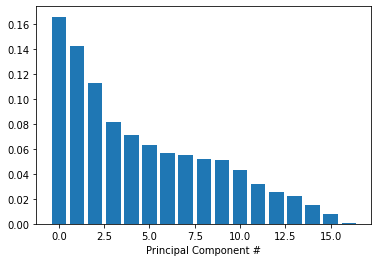

In [88]:
pca = PCA()
pca.fit(scaled_features)
# get explained variance ratios from PCA using all features
exp_variance = pca.explained_variance_ratio_
# plot explained variance
fig, ax= plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')

### 1.2 cumulative explained variance plot¶

Optimal number of components: 11
Explained variation per principal component:
[0.16622073 0.14263327 0.11289505 0.08168341 0.07112491 0.06332291
 0.05703597 0.05511118 0.05203352 0.05096468 0.04336432 0.03206704
 0.02533429 0.02243046 0.01519051 0.00768408 0.00090369]


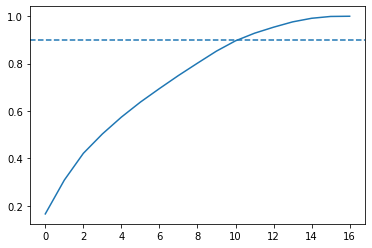

In [89]:
# calculate the cumulative explained variance
cum_exp_var = np.cumsum(exp_variance)

# plot the cumulative explained variance and draw a dashed line at 0.9\
# This line indicates how much variance (information) we want to retain
fig, ax= plt.subplots()
ax.plot(cum_exp_var)
ax.axhline(y=0.9, linestyle='--')

# find index where cum_exp_var exceeds 0.9 and adding 1 to that index to get the num of components
n_components = ((np.where(cum_exp_var > 0.9))[0][0])
print(f"Optimal number of components: {n_components}")
print(f"Explained variation per principal component:\n{pca.explained_variance_ratio_}")
# perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components,random_state=10)
pca.fit(scaled_features)
pca_proj = pca.transform(scaled_features)

### 1.3 plot PCA in 2D

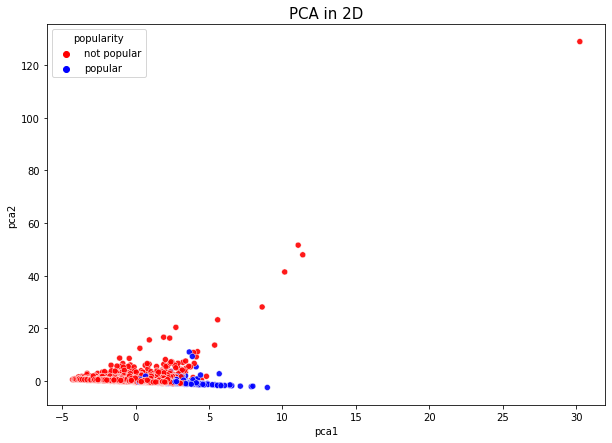

In [90]:
# generating df for plotting PCA
df = pd.DataFrame()
df['pca1'] = pca_proj[:,0]
df['pca2'] = pca_proj[:,1]
df['pca3'] = pca_proj[:,2]
df['popularity'] = labels.apply(lambda x: "popular" if x==1 else "not popular")
# plot scatter of PCA
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="pca1", y="pca2",
    hue='popularity',
    palette={'popular':'blue','not popular':'red'},
    data=df,
    legend="full",
    alpha=0.9
)
plt.title("PCA in 2D", fontsize= 15)
plt.show()

Should the PCA projection be normalized even after?

# 1.4 plot PCA in 3D¶

In [91]:
# 3D PCA
#total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    df, x='pca1', y='pca2', z='pca3', color='popularity',
    #title=f'Total Explained Variance: {total_var:.2f}%',
    #labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=0.6
))
fig.show()

# 2. Model selection¶

In [92]:
# shuffle and split into development set and internal test set:

# (PCA)
Xpca_develop, Xpca_test, y_develop_pca, y_test_pca = train_test_split(
pca_proj, labels, test_size=0.30, random_state=10)

# (no PCA)
X_develop, X_test, y_develop, y_test = train_test_split(
scaled_features, labels, test_size=0.30, random_state=10)

In [93]:
# check partition
print(f"____Legend____\n0: not popular\n1: popular\n\n***PCA***\nDevelopment set:\
\n{y_develop_pca.value_counts()}\n\nInternal Test:\n{y_test_pca.value_counts()}\n\n\
-----------------\n\
***No-PCA***\nDevelopment set:\n{y_develop.value_counts()}\n\nInternal Test:\n{y_test.value_counts()}")

____Legend____
0: not popular
1: popular

***PCA***
Development set:
0    8647
1     543
Name: popularity, dtype: int64

Internal Test:
0    3728
1     211
Name: popularity, dtype: int64

-----------------
***No-PCA***
Development set:
0    8647
1     543
Name: popularity, dtype: int64

Internal Test:
0    3728
1     211
Name: popularity, dtype: int64


# 2.1 Decision Tree -  Unbalanced - without PCA
### 2.1.1 10 fold cross validation - grid search

In [94]:
param_grid = {
               "max_depth": [2,3,4,5,6,7,8,9,10, None],
               "min_samples_leaf": [25,35,45,55,75,100,150,250,300,None],
               "criterion": ["gini", "entropy"]
             }
# model
dtc = DecisionTreeClassifier()
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
random_search = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2, verbose=True)

random_search.fit(X_develop, y_develop)
dtc=random_search.best_estimator_
report(random_search.cv_results_, n_top=10)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Model with rank: 1
Mean validation score: 0.980 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.980 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.980 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.980 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.980 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.980 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.980 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': None, 'min

### 2.1.2 5 fold cross validation - grid search

In [95]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2, verbose=True)

random_search.fit(X_develop, y_develop)
dtc=random_search.best_estimator_
report(random_search.cv_results_, n_top=10)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Model with rank: 1
Mean validation score: 0.981 (std: 0.002)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.981 (std: 0.002)
Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.981 (std: 0.002)
Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.981 (std: 0.002)
Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.981 (std: 0.002)
Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.981 (std: 0.002)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.981 (std: 0.002)
Parameters: {'criterion': 'entropy', 'ma

### 2.1.3 Retrain on full development set and prediction

Accuracy 0.9781670474739782
F1-score [0.98846567 0.79620853]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3728
           1       0.80      0.80      0.80       211

    accuracy                           0.98      3939
   macro avg       0.89      0.89      0.89      3939
weighted avg       0.98      0.98      0.98      3939



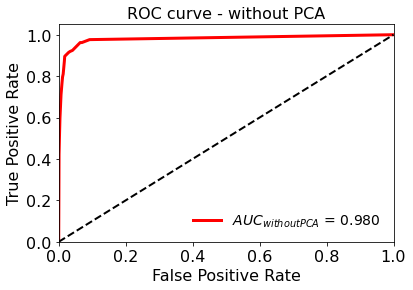

In [96]:
dtc = DecisionTreeClassifier(criterion= 'entropy',max_depth=5, min_samples_leaf= 35)
dtc.fit(X_develop,y_develop)

y_pred_dtc = dtc.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))

# y_score0 --> scores of decision tree without PCA
# fpr0, tpr0 ---> false positive and true positive of decision tree without PCA
y_score0 = dtc.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score0[:, 1])

# roc_auc0 --> ROC/AUC of decision tree without PCA
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='red', lw=3, label='$AUC_{without PCA}$ = %.3f' % roc_auc0)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - without PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Legend:
0: not popular
1: popular
[[3685   43]
 [  43  168]]


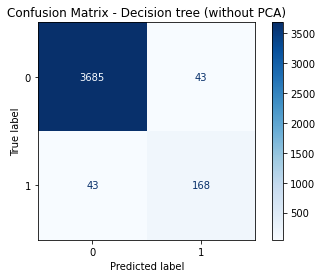

In [97]:
# confusion matrix - Internal Test
print("Legend:\n0: not popular\n1: popular")
cm = plot_confusion_matrix(dtc,X_test,y_test,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix - Decision tree (without PCA)')
print(cm.confusion_matrix)
plt.show()

# 2.2 Decision Tree -  Unbalanced - with PCA
### 2.2.1 10 fold cross validation - grid search

In [98]:
# model
dtc_pca = DecisionTreeClassifier()
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
random_search_pca = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2, verbose=True)

random_search_pca.fit(Xpca_develop, y_develop_pca)
dtc_pca=random_search_pca.best_estimator_
report(random_search_pca.cv_results_, n_top=10)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Model with rank: 1
Mean validation score: 0.965 (std: 0.005)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 35}

Model with rank: 2
Mean validation score: 0.964 (std: 0.007)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 25}

Model with rank: 3
Mean validation score: 0.964 (std: 0.006)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 75}

Model with rank: 3
Mean validation score: 0.964 (std: 0.006)
Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 75}

Model with rank: 3
Mean validation score: 0.964 (std: 0.006)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 75}

Model with rank: 3
Mean validation score: 0.964 (std: 0.006)
Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 75}

Model with rank: 3
Mean validation score: 0.964 (std: 0.006)
Parameters: {'criterion': 'gini', 'max_depth': 9, 'min_sam

### 2.2.2 5 fold cross validation - grid search

In [99]:
dtc_pca = DecisionTreeClassifier()
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search_pca = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2, verbose=True)

random_search_pca.fit(Xpca_develop, y_develop_pca)
dtc_pca=random_search_pca.best_estimator_
report(random_search_pca.cv_results_, n_top=10)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Model with rank: 1
Mean validation score: 0.964 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 25}

Model with rank: 1
Mean validation score: 0.964 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 25}

Model with rank: 1
Mean validation score: 0.964 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 25}

Model with rank: 4
Mean validation score: 0.964 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 25}

Model with rank: 5
Mean validation score: 0.964 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 25}

Model with rank: 6
Mean validation score: 0.964 (std: 0.005)
Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 35}

Model with rank: 7
Mean validation score: 0.964 (std: 0.005)
Parameters: {'criterion': 'entropy', 

### 2.2.3 Retrain on full development set and prediction

Accuracy 0.9644579842599644
F1-score [0.98147168 0.56521739]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3728
           1       0.82      0.43      0.57       211

    accuracy                           0.96      3939
   macro avg       0.89      0.71      0.77      3939
weighted avg       0.96      0.96      0.96      3939



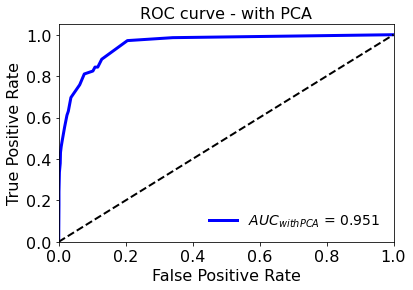

In [100]:
dtc_pca = DecisionTreeClassifier(criterion= 'gini',max_depth=5, min_samples_leaf= 35)
dtc_pca.fit(Xpca_develop,y_develop_pca)

y_pred_dtc_pca = dtc_pca.predict(Xpca_test)

print('Accuracy %s' % accuracy_score(y_test_pca, y_pred_dtc_pca))
print('F1-score %s' % f1_score(y_test_pca, y_pred_dtc_pca, average=None))
print(classification_report(y_test_pca, y_pred_dtc_pca))

# y_score1 --> scores of decision tree with PCA
# fpr1, tpr1 ---> false positive and true positive of decision tree with PCA
y_score1 = dtc_pca.predict_proba(Xpca_test)
fpr1, tpr1, _ = roc_curve(y_test_pca, y_score1[:, 1])

# roc_auc1 --> ROC/AUC of decision tree with PCA
roc_auc1 = auc(fpr1, tpr1)

plt.plot(fpr1, tpr1, color='blue', lw=3, label='$AUC_{with PCA}$ = %.3f' % roc_auc1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - with PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Legend:
0: not popular
1: popular
[[3708   20]
 [ 120   91]]


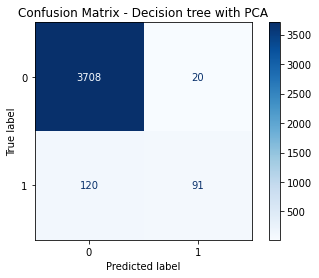

In [101]:
# confusion matrix Decision tree with PCA
print("Legend:\n0: not popular\n1: popular")
cm_pca = plot_confusion_matrix(dtc_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_pca.ax_.set_title('Confusion Matrix - Decision tree with PCA')
print(cm_pca.confusion_matrix)
plt.show()

# 2.3 Comparing ROC Decision tree (unbalanced) with and without PCA

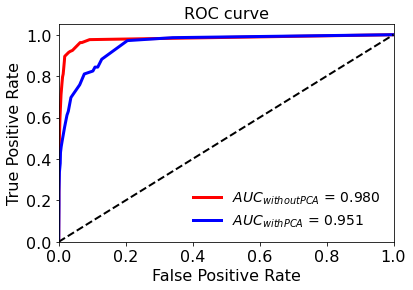

In [102]:
plt.plot(fpr0, tpr0, color='red', lw=3, label='$AUC_{without PCA}$ = %.3f' % roc_auc0)
plt.plot(fpr1, tpr1, color='blue', lw=3, label='$AUC_{with PCA}$ = %.3f' % roc_auc1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# 3.1 KNN binary class - Unbalanced (without PCA)

### 3.1.1 10 fold cross validation - grid search

In [103]:
# range of k to try - find a good range of k
k_range = range(1, 250)
# empty list to store scores
k_scores = []

for k in tqdm(k_range):
    # run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X_develop, y_develop, cv=10, scoring='accuracy')
    # append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

print(k_scores)
print(f"maximum score: {max(k_scores)} for k = {k_scores.index(max(k_scores))+1}")

100%|██████████| 249/249 [08:26<00:00,  2.04s/it]


[0.9466811751904242, 0.9573449401523394, 0.9553862894450489, 0.9560391730141458, 0.9563656147986942, 0.9562568008705113, 0.957562568008705, 0.95582154515778, 0.9572361262241567, 0.95582154515778, 0.9561479869423286, 0.9559303590859629, 0.9557127312295973, 0.9560391730141458, 0.9566920565832426, 0.9558215451577802, 0.9563656147986942, 0.9559303590859629, 0.9565832426550598, 0.9554951033732317, 0.9559303590859629, 0.9554951033732317, 0.9559303590859629, 0.9553862894450489, 0.9556039173014146, 0.9551686615886833, 0.9553862894450489, 0.9550598476605006, 0.9552774755168661, 0.9542981501632208, 0.9546245919477693, 0.9540805223068551, 0.9542981501632208, 0.9544069640914037, 0.9546245919477693, 0.9541893362350379, 0.9541893362350379, 0.9540805223068551, 0.9541893362350379, 0.9539717083786723, 0.9541893362350379, 0.9538628944504894, 0.9541893362350379, 0.9541893362350379, 0.9541893362350379, 0.9538628944504894, 0.9539717083786723, 0.9537540805223067, 0.9538628944504894, 0.9536452665941239, 0.95

Text(0, 0.5, 'Cross-validated accuracy')

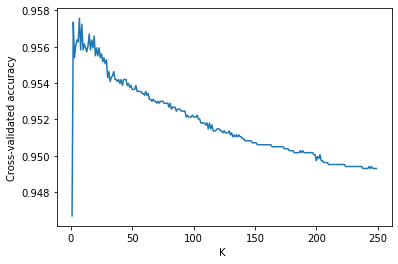

In [104]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('K ')
plt.ylabel('Cross-validated accuracy')

## 3.1.2 Prediction on Internal test set (KNN - without PCA)

In [105]:
X_test.shape, y_test.shape

((3939, 17), (3939,))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3728
           1       0.83      0.30      0.44       211

    accuracy                           0.96      3939
   macro avg       0.90      0.65      0.71      3939
weighted avg       0.95      0.96      0.95      3939

legend:
0: Hip-Hop
1: Rock


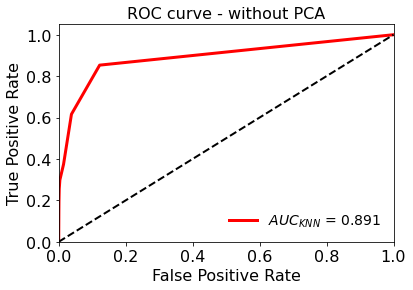

In [106]:
knn_classifier =  KNeighborsClassifier(n_neighbors = 7)

# retrain knn on the whole development set
knn_classifier.fit(X_develop, y_develop)
# predict target variable
y_pred_knn0 = knn_classifier.predict(X_test)
# display classification report
print(classification_report(y_test, y_pred_knn0))
print('legend:\n0: Hip-Hop\n1: Rock')

# plot ROC curve -KNN
y_score_knn0 = knn_classifier.predict_proba(X_test)
fpr_knn0, tpr_knn0, _ = roc_curve(y_test, y_score_knn0[:, 1])
roc_auc_knn0 = auc(fpr_knn0, tpr_knn0)

plt.plot(fpr_knn0, tpr_knn0, color='red', lw=3, label='$AUC_{KNN}$ = %.3f' % roc_auc_knn0)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - without PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Legend:
0: no pupular
1: popular
[[3715   13]
 [ 148   63]]


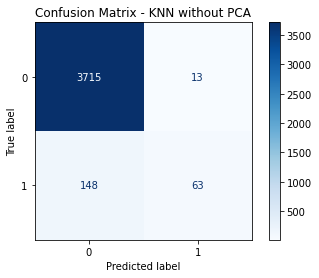

In [107]:
# confusion matrix KNN - Internal test
print("Legend:\n0: no pupular\n1: popular")
cm_knn = plot_confusion_matrix(knn_classifier,X_test,y_test,
                            cmap = plt.cm.Blues)
cm_knn.ax_.set_title('Confusion Matrix - KNN without PCA')
print(cm_knn.confusion_matrix)
plt.show()

# 3.2 KNN binary class - Unbalanced (with PCA)
### 3.2.1 10 fold cross validation - grid search

In [108]:
# range of k to try - find a good range of k
k_range = range(1, 250)
# empty list to store scores
k_scores = []

for k in tqdm(k_range):
    # run KNeighborsClassifier with k neighbours
    knn_pca = KNeighborsClassifier(n_neighbors=k)
    # obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn_pca, Xpca_develop, y_develop_pca, cv=10, scoring='accuracy')
    # append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

print(k_scores)
print(f"maximum score: {max(k_scores)} for k = {k_scores.index(max(k_scores))+1}")

100%|██████████| 249/249 [11:00<00:00,  2.65s/it]


[0.9482045701849836, 0.957562568008705, 0.9577801958650707, 0.9573449401523394, 0.9585418933623503, 0.9578890097932534, 0.9585418933623503, 0.9577801958650707, 0.9589771490750817, 0.9588683351468987, 0.9590859630032643, 0.957562568008705, 0.9578890097932534, 0.9571273122959738, 0.9576713819368878, 0.9565832426550598, 0.9573449401523394, 0.957018498367791, 0.9571273122959738, 0.9565832426550598, 0.957018498367791, 0.9565832426550598, 0.957018498367791, 0.9565832426550598, 0.9566920565832426, 0.9559303590859629, 0.9561479869423286, 0.9558215451577802, 0.9561479869423286, 0.9557127312295973, 0.9559303590859629, 0.9556039173014146, 0.9558215451577802, 0.9554951033732317, 0.9554951033732317, 0.9551686615886833, 0.9551686615886833, 0.9550598476605006, 0.9551686615886833, 0.9550598476605006, 0.9553862894450489, 0.9546245919477693, 0.9550598476605006, 0.9547334058759521, 0.9550598476605006, 0.9544069640914037, 0.9545157780195865, 0.9542981501632208, 0.9546245919477693, 0.9541893362350379, 0.95

Text(0, 0.5, 'Cross-validated accuracy')

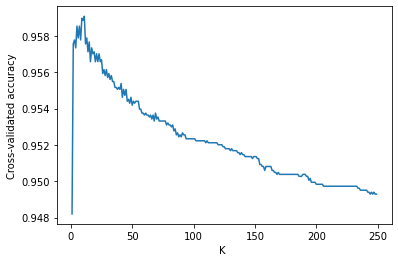

In [109]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('K ')
plt.ylabel('Cross-validated accuracy')

## 3.1.2 Prediction on Internal test set (KNN - with PCA)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3728
           1       0.84      0.27      0.41       211

    accuracy                           0.96      3939
   macro avg       0.90      0.64      0.70      3939
weighted avg       0.95      0.96      0.95      3939

legend:
0: not popular
1: popular


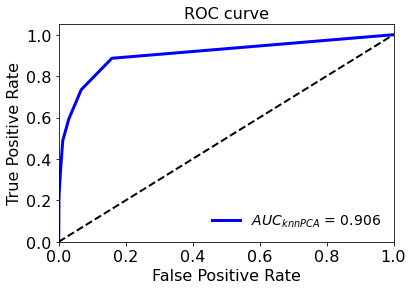

In [110]:
knn_classifier_pca =  KNeighborsClassifier(n_neighbors = 11)

# retrain knn on the whole development set
knn_classifier_pca.fit(Xpca_develop, y_develop_pca)
# predict target variable
y_pred_knn1 = knn_classifier_pca.predict(Xpca_test)
# display classification report
print(classification_report(y_test_pca, y_pred_knn1))
print('legend:\n0: not popular\n1: popular')

# plot ROC curve -KNN
y_score_knn1 = knn_classifier_pca.predict_proba(Xpca_test)
fpr_knn1, tpr_knn1, _ = roc_curve(y_test_pca, y_score_knn1[:, 1])
roc_auc_knn1 = auc(fpr_knn1, tpr_knn1)

plt.plot(fpr_knn1, tpr_knn1, color='blue', lw=3, label='$AUC_{knnPCA}$ = %.3f' % roc_auc_knn1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Legend:
0: no pupular
1: popular
[[3717   11]
 [ 153   58]]


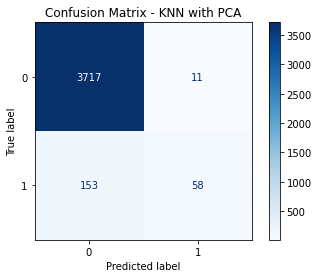

In [111]:
# confusion matrix KNN - Internal test
print("Legend:\n0: no pupular\n1: popular")
cm_knnpca = plot_confusion_matrix(knn_classifier_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_knnpca.ax_.set_title('Confusion Matrix - KNN with PCA')
print(cm_knnpca.confusion_matrix)
plt.show()

# Compare KNN ROC with and without PCA

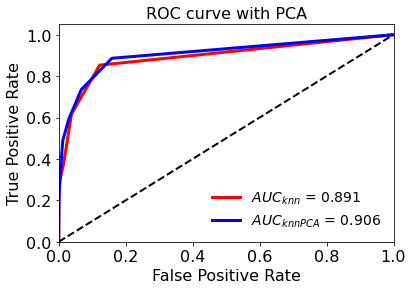

In [112]:
plt.plot(fpr_knn0, tpr_knn0, color='red', lw=3, label='$AUC_{knn}$ = %.3f' % roc_auc_knn0)
plt.plot(fpr_knn1, tpr_knn1, color='blue', lw=3, label='$AUC_{knnPCA}$ = %.3f' % roc_auc_knn1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve with PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Compare Decision tree and KNN (best scores)

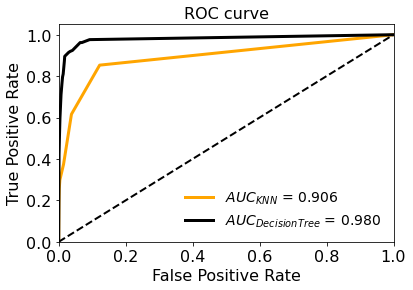

In [113]:
plt.plot(fpr_knn0, tpr_knn0, color='orange', lw=3, label='$AUC_{KNN}$ = %.3f' % roc_auc_knn1)
plt.plot(fpr0, tpr0, color='black', lw=3, label='$AUC_{DecisionTree}$ = %.3f' % roc_auc0)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()